In [243]:
import numpy as np
print(np)
%matplotlib nbagg
import matplotlib
from scipy import special

<module 'numpy' from '/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/numpy/__init__.py'>


In [343]:
import dedalus.public as de
import numpy as np
import matplotlib.pylab as plt

In [360]:
nr1 = 64
r_shortgrid = de.Chebyshev('r', nr1, interval=(10, 20))
d1 = de.Domain([r_shortgrid])

nr2 = 92
r_longgrid = de.Chebyshev('r', nr2, interval=(10, 20))
d2 = de.Domain([r_longgrid])

In [361]:
# critical parameters
r1 = 10.
r2 = 20.

mu_omega = 0.27
eta_omega = r1/r2

c1 = (mu_omega - eta_omega**2)/(1 - eta_omega**2)
c2 = ((1 - mu_omega)/(1 - eta_omega**2))*r1**2

# Hollerbach & Rudiger 2005
Pm = 1.0E-6
Re = 1521
xi = 4
Q = 2.33
k = Q

iR = 1.0/Re
Rm = Pm*Re
iRm = 1.0/Rm

Ha = 16.3
beta = (2*Re*Rm)/(Ha**2)

magnetic_bcs = "insulating"
#magnetic_bcs = "conducting"

In [362]:
widegap1 = de.EVP(d1,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')
widegap2 = de.EVP(d2,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

for widegap in [widegap1, widegap2]:
    widegap.parameters['k'] = Q
    widegap.parameters['iR'] = iR
    widegap.parameters['iRm'] = iRm
    widegap.parameters['beta'] = beta
    widegap.parameters['c1'] = c1
    widegap.parameters['c2'] = c2
    widegap.parameters['B0'] = 1
    widegap.parameters['xi'] = xi
    widegap.parameters['r1'] = r1
    widegap.parameters['r2'] = r2
    #widegap.parameters['bessel1'] = special.iv
    widegap.parameters['bessel1'] = special.iv(0, k*r1)/special.iv(1, k*r1)
    widegap.parameters['bessel2'] = special.kn(0, k*r2)/special.kn(1, k*r2)
    
    widegap.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
    widegap.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
    widegap.substitutions['dz'] = '(1j*k)'
    widegap.substitutions['twooverbeta'] = '(2.0/beta)'
    widegap.substitutions['psivisc'] = '(r**4*dr(psirrr) + r**4*dz**4*psi + r**4*2*dz**2*psirr + 3*r*psir - 3*r**2*psirr + 2*r**3*psirrr + 2*r**3*dz**2*psir - 2*r**2*dz**2*psi - 3*psi)'
    widegap.substitutions['uvisc'] = '(r**2*dr(ur) + r**2*dz**2*u + r*ur - u)'
    widegap.substitutions['Avisc'] = '(r**2*dr(Ar) + r**2*dz**2*A + r*Ar - A)' 
    widegap.substitutions['Bvisc'] = '(r**2*dr(Br) + r**2*dz**2*B + r*Br - B)'
    
    # psi multiplied by r**4, others by r**2
    widegap.add_equation("sigma*(r**4*psirr + r**4*dz**2*psi + r**3*psir - r**2*psi) - 2*r**2*ru0*dz*u - twooverbeta*B0*dz*(r**4*dr(Ar) + r**4*dz**2*A + r**3*Ar - r**2*A) + twooverbeta*r**2*2*xi*B0*dz*B - iR*psivisc = 0")
    widegap.add_equation("sigma*r**2*u + ru0*dz*psi + rrdu0*dz*psi - r**2*twooverbeta*B0*dz*B - iR*uvisc = 0") 
    widegap.add_equation("sigma*r**2*A - r**2*B0*dz*psi - iRm*Avisc = 0")
    widegap.add_equation("sigma*r**2*B + ru0*dz*A - r**2*B0*dz*u - rrdu0*dz*A - 2*xi*B0*dz*psi - iRm*Bvisc = 0") 

    widegap.add_equation("dr(psi) - psir = 0")
    widegap.add_equation("dr(psir) - psirr = 0")
    widegap.add_equation("dr(psirr) - psirrr = 0")
    widegap.add_equation("dr(u) - ur = 0")
    widegap.add_equation("dr(A) - Ar = 0")
    widegap.add_equation("dr(B) - Br = 0")
    
    widegap.add_bc('left(u) = 0')
    widegap.add_bc('right(u) = 0')
    widegap.add_bc('left(psi) = 0')
    widegap.add_bc('right(psi) = 0')
    widegap.add_bc('left(psi + r*psir) = 0')
    widegap.add_bc('right(psi + r*psir) = 0')
    if magnetic_bcs == "conducting":
        widegap.add_bc('left(A) = 0')
        widegap.add_bc('right(A) = 0')
        widegap.add_bc('left(B + r*Br) = 0')
        widegap.add_bc('right(B + r*Br) = 0')

    if magnetic_bcs == "insulating":
        widegap.add_bc('left(dr(r*dz*A) - k*r*bessel1*dz*A) = 0')
        widegap.add_bc('right(dr(r*dz*A) + k*r*bessel2*dz*A) = 0')
        widegap.add_bc('left(B) = 0')
        widegap.add_bc('right(B) = 0')


2016-06-17 11:25:54,975 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-06-17 11:25:54,976 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [363]:
widegap_solver1 = widegap1.build_solver()
widegap_solver2 = widegap2.build_solver()

In [364]:
widegap_solver1.solve(widegap_solver1.pencils[0])
widegap_solver2.solve(widegap_solver2.pencils[0])

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta


In [365]:
ev1 = widegap_solver1.eigenvalues
ev2 = widegap_solver2.eigenvalues

In [366]:
def discard_spurious_eigenvalues(lambda1, lambda2):
    
    """
    lambda1 :: eigenvalues from low res run
    lambda2 :: eigenvalues from high res run

    Solves the linear eigenvalue problem for two different resolutions.
    Returns trustworthy eigenvalues using nearest delta, from Boyd chapter 7.
    """

    # Reverse engineer correct indices to make unsorted list from sorted
    reverse_lambda1_indx = np.arange(len(lambda1)) 
    reverse_lambda2_indx = np.arange(len(lambda2))

    lambda1_and_indx = np.asarray(list(zip(lambda1, reverse_lambda1_indx)))
    lambda2_and_indx = np.asarray(list(zip(lambda2, reverse_lambda2_indx)))

    # remove nans
    lambda1_and_indx = lambda1_and_indx[np.isfinite(lambda1)]
    lambda2_and_indx = lambda2_and_indx[np.isfinite(lambda2)]

    # Sort lambda1 and lambda2 by real parts
    lambda1_and_indx = lambda1_and_indx[np.argsort(lambda1_and_indx[:, 0].real)]
    lambda2_and_indx = lambda2_and_indx[np.argsort(lambda2_and_indx[:, 0].real)]

    lambda1_sorted = lambda1_and_indx[:, 0]
    lambda2_sorted = lambda2_and_indx[:, 0]

    # Compute sigmas from lower resolution run (gridnum = N1)
    sigmas = np.zeros(len(lambda1_sorted))
    sigmas[0] = np.abs(lambda1_sorted[0] - lambda1_sorted[1])
    sigmas[1:-1] = [0.5*(np.abs(lambda1_sorted[j] - lambda1_sorted[j - 1]) + np.abs(lambda1_sorted[j + 1] - lambda1_sorted[j])) for j in range(1, len(lambda1_sorted) - 1)]
    sigmas[-1] = np.abs(lambda1_sorted[-2] - lambda1_sorted[-1])

    if not (np.isfinite(sigmas)).all():
        print("WARNING: at least one eigenvalue spacings (sigmas) is non-finite (np.inf or np.nan)!")

    # Nearest delta
    delta_near = np.array([np.nanmin(np.abs(lambda1_sorted[j] - lambda2_sorted)/sigmas[j]) for j in range(len(lambda1_sorted))])

    # Discard eigenvalues with 1/delta_near < 10^6
    lambda1_and_indx = lambda1_and_indx[np.where((1.0/delta_near) > 1E6)]
    #print(lambda1_and_indx)

    lambda1 = lambda1_and_indx[:, 0]
    indx = lambda1_and_indx[:, 1]

    return lambda1, indx

In [367]:
goodeigs, goodeigs_indices = discard_spurious_eigenvalues(ev1, ev2)

In [368]:
def ploteigs(goodevals):

    """
    Plot real vs imaginary parts of eigenvalues.
    """
    
    # Color is sign of imaginary part
    colors = ["blue" for i in range(len(goodevals))]
    imagpos = np.where(goodevals.imag >= 0)
    for p in imagpos[0]:
        colors[p] = "red"
  
    # Symbol is sign of real part
    symbols = ["." for i in range(len(goodevals))]
    thickness = np.zeros(len(goodevals))
    realpos = np.where(goodevals.real >= 0)
    for p in realpos[0]:
        symbols[p] = "+"
        thickness[p] = 2
    
    print("Number of positive real parts", len(realpos[0]))
    
    for x, y, c, s, t in zip(np.abs(goodevals.real), np.abs(goodevals.imag), colors, symbols, thickness):
        plt.plot(x, y, s, c=c, alpha = 0.5, ms = 8, mew = t)
        
    # Dummy plot for legend
    plt.plot(0, 0, '+', c = "red", alpha = 0.5, mew = 2, label = r"$\gamma \geq 0$, $\omega > 0$")
    plt.plot(0, 0, '+', c = "blue", alpha = 0.5, mew = 2, label = r"$\gamma \geq 0$, $\omega < 0$")
    plt.plot(0, 0, '.', c = "red", alpha = 0.5, label = r"$\gamma < 0$, $\omega > 0$")
    plt.plot(0, 0, '.', c = "blue", alpha = 0.5, label = r"$\gamma < 0$, $\omega < 0$")
        
    plt.legend()
        
    plt.loglog()
    plt.xlabel(r"$\left|\gamma\right|$", size = 15)
    plt.ylabel(r"$\left|\omega\right|$", size = 15, rotation = 0)
    plt.title(r"$\mathrm{HMRI}$ $\mathrm{eigenvalues}$ $\lambda = \gamma + i \omega$")

There are 56 goodeigs
[ -6.19717767e+04 -4.45405077e-07j  -5.44446619e+04 +6.31036683e-07j
  -5.08757707e+04 -9.73309403e-07j  -4.74366570e+04 -1.01355810e-07j
  -4.41273212e+04 +2.38101654e-07j  -4.09477631e+04 -9.31887827e-07j
  -3.78979827e+04 +3.93889386e-09j  -3.49779800e+04 -2.15270333e-07j
  -3.21877549e+04 +6.89498295e-08j  -2.95273075e+04 +2.18994949e-07j
  -2.69966376e+04 -6.52707531e-08j  -2.45957454e+04 +1.03479878e-07j
  -2.23246306e+04 +1.11030929e-08j  -2.01832932e+04 +1.68682456e-07j
  -1.81717332e+04 +1.37300281e-07j  -1.62899505e+04 +1.50049048e-07j
  -1.45379450e+04 +2.04185713e-07j  -1.29157164e+04 +3.19669388e-07j
  -1.14232647e+04 +3.26466162e-07j  -1.00605897e+04 +5.07600688e-07j
  -8.82769106e+03 +7.47167782e-07j  -7.72456867e+03 +1.26133351e-06j
  -6.75122225e+03 +1.96323198e-06j  -5.90765156e+03 +3.43703367e-06j
  -5.19385638e+03 +6.18856862e-06j  -4.60983621e+03 +1.18425477e-05j
  -4.15558903e+03 +2.52378578e-05j  -3.83110451e+03 +6.35973870e-05j
  -3.6363052

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


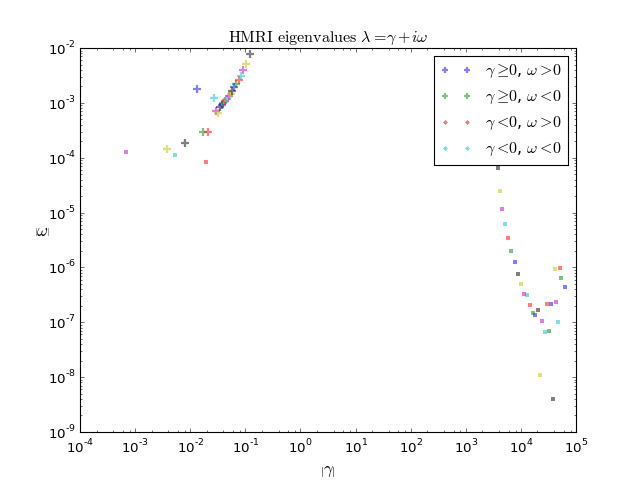

Number of positive real parts 23


In [369]:
print("There are {} goodeigs".format(len(goodeigs)))
print(goodeigs)
plt.figure()
ploteigs(goodeigs)

In [370]:
marginal_mode_index = np.where(np.abs(goodeigs.real) == np.nanmin(np.abs(goodeigs.real)))[0][0]
use_indx = int(goodeigs_indices[marginal_mode_index])

print(goodeigs[marginal_mode_index])
print(goodeigs[goodeigs.real > 0])
print(goodeigs[goodeigs.imag == np.max(goodeigs.imag)])

(-0.000694559848976+0.000125548947957j)
[ 0.00379243+0.00014562j  0.00815160+0.00018912j  0.01336087+0.00178495j
  0.01685692+0.00029512j  0.02078720+0.0002885j   0.02685728+0.00122122j
  0.02890173+0.00070137j  0.03194151+0.00064235j  0.03461528+0.00083606j
  0.03719604+0.00092303j  0.04004043+0.00097757j  0.04310653+0.00107239j
  0.04641838+0.00118632j  0.05003144+0.00131727j  0.05399730+0.00147693j
  0.05839166+0.0016662j   0.06330017+0.001909j    0.06887002+0.00220393j
  0.07526348+0.00261598j  0.08283258+0.00313359j  0.09194767+0.00398513j
  0.10386976+0.00512592j  0.12009439+0.00779558j]
[ 0.12009439+0.00779558j]


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [371]:
rr  = r_shortgrid.grid()
evector = widegap_solver1.eigenvectors[use_indx]
widegap_solver1.set_state(use_indx)
data = widegap_solver1.state

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


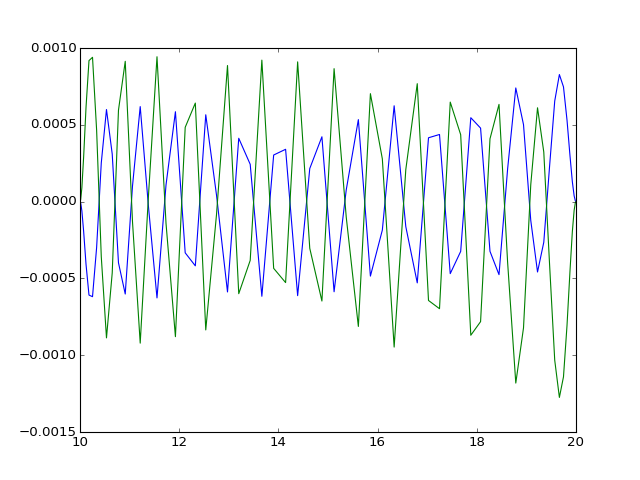

In [372]:
plt.figure()
plt.plot(rr, (data['psi']['g']).real, label='real')
plt.plot(rr, (data['psi']['g']).imag, label='imag')

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


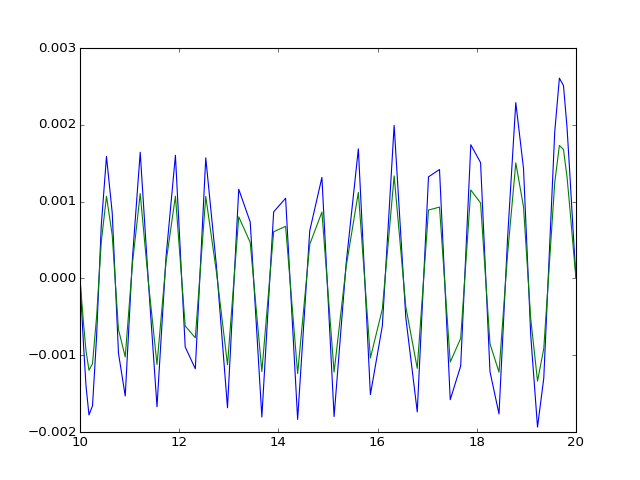

In [373]:
plt.figure()
plt.plot(rr, (data['u']['g']).real, label='real')
plt.plot(rr, (data['u']['g']).imag, label='imag')

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


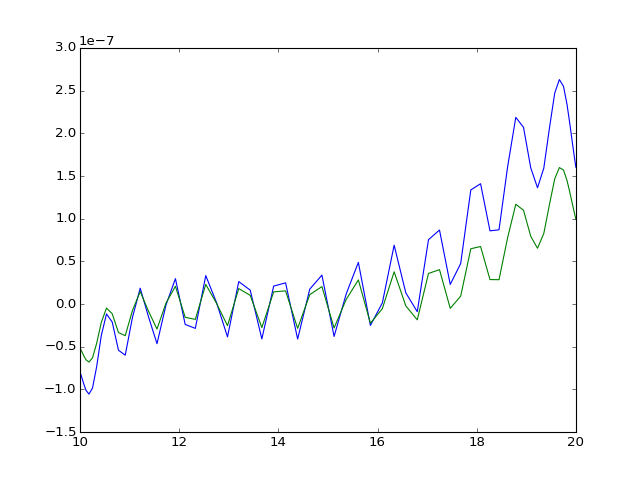

In [374]:
plt.figure()
plt.plot(rr, (data['A']['g']).real, label='real')
plt.plot(rr, (data['A']['g']).imag, label='imag')

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/matplotlib-1.4.3-py3.5-macosx-10.9-x86_64.egg/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


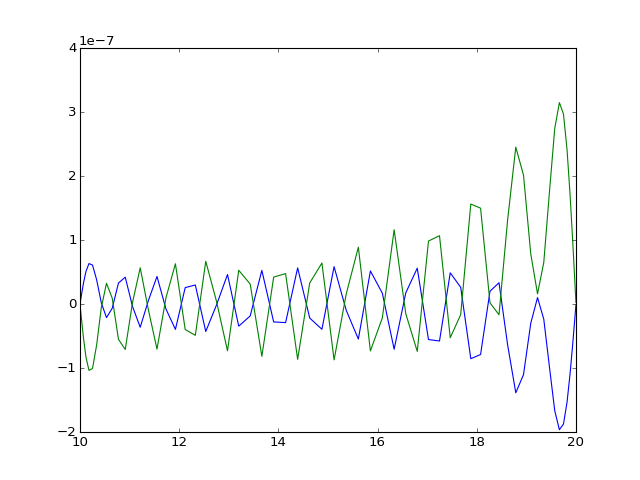

In [375]:
plt.figure()
plt.plot(rr, (data['B']['g']).real, label='real')
plt.plot(rr, (data['B']['g']).imag, label='imag')